In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [86]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [87]:
x = torch.tensor([1.5])
w = torch.tensor([1.], requires_grad=True)
y = torch.tensor([0.5])

y_hat = x * w    
loss = (y_hat-y)**2 # Mean square difference
loss.backward()
w.grad

tensor([3.])

In [88]:
optimizer = optim.SGD([w], lr=0.01)
optimizer.step()

In [89]:
loss.grad_fn.next_functions[0][0].next_functions

((<MulBackward0 at 0x1b81d584640>, 0), (None, 0))

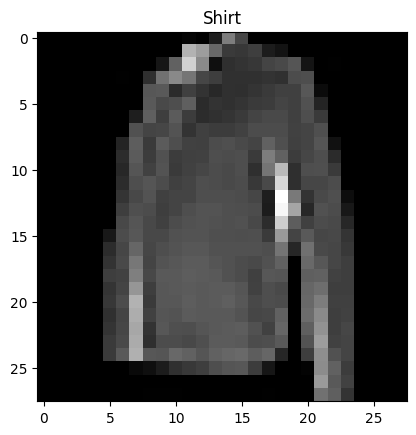

In [90]:
data = pd.read_csv('data/fashionmnist_train.csv').to_numpy()
idx = np.random.randint(0, 500)
plt.imshow(data[idx, 1:].reshape(28, 28), cmap='gray')
plt.title(classes[data[idx, 0]])
plt.show()

In [91]:
# Define Dataset class, which tells PyTorch how to load data
class myDataset(Dataset):

    def __init__(self,csv_file):
        self.data = pd.read_csv(csv_file).to_numpy()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        x = self.data[idx,1:] / 255
        y = self.data[idx,0]

        return x,y

In [92]:
# Initialize the dataset and dataloader
dataset_train = myDataset('data/fashionmnist_train.csv')
dataset_test = myDataset('data/fashionmnist_test.csv')

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=False)
loader_test = DataLoader(dataset_train, batch_size=32, shuffle=False)

In [93]:
for x, y in loader_train:
    print(x[0:1])

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2431, 0.2392, 0.0824, 0.1137, 0.0902,
         0.2000, 0.5333, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [ ]:
# Define our model and training and testing procedures
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the layers of the model
        self.layer1 = nn.Linear(784, 256) # 784 input features, 256 output features
        self.layer2 = nn.Linear(256, 64)
        self.layer3 = nn.Linear(64, 10)
    
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = F.relu(self.layer3(out))
        return out

    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):

        self.loss_train_log = []
        self.loss_test_log = []

        for epoch in range(epochs):

            #in every epoch, we will:
            # (1) Loop over loader_train, forward pass, calculate loss, backpropagate, update weight
            # (2) Calculate loss for training and save it
            # (3) Calculage loss for testing and save it

            # Step 1
            for x,y in loader_train:
                x = x.to(dtype=torch.float)
                y = y.to(dtype=torch.long) # Classification torch.long, regression torch.float

                # Reset the gradient
                optimizer.zero_grad() # To make sure gradient is 0

                # Forward pass and calculate loss, backpropagate, update weight
                y_hat = self.forward(x)
                loss = F.cross_entropy(y_hat, y)
                loss.backward()
                optimizer.step()

            # Step 2
            loss_train = self.evaluate(loader_train)
            self.loss_train_log = [loss_train]

            # Step 3 
            loss_test = self.evaluate(loader_test)
            self.loss_test_log = [loss_test]

            # Step 4
            if verbose:
                print(f'Epoch {epoch+1}/{epochs}, Loss train: {loss_train:.4f}, Loss test: {loss_test:.4f}')

            # Step 5
            if loss_test < self.best_loss:
                self.best_loss = loss_test
                best_epoch = epoch + 1
                torch.save(self.state_dict(), 'best_param.pt')
            
            print(f'')

    def evaluate(self,loader):

        loss = 0

        with torch.no_grad():
            for x,y in loader:
                x = x.to(dtype=torch.float)
                y = y.to(dtype=torch.long) # Classification torch.long, regression torch.float

                y_hat = self.forward(x)
                loss += F.cross_entropy(y_hat, y, reduction='sum')

        loss /= len(loader.dataset)
        return loss

In [96]:
from unittest import loader

epochs = 10
model = MLP()
optimizer = optim.Adam(model.parameters(), lr = 0.005)
model.Train(epochs, optimizer, loader_train, loader_test)

Epoch 1/10, Loss train: 1.3837, Loss test: 1.3837


AttributeError: 'MLP' object has no attribute 'best_loss'

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

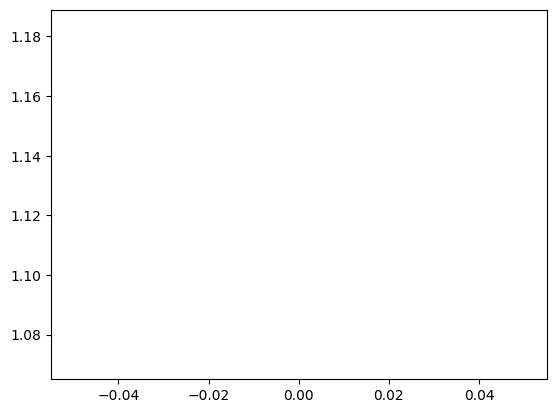

In [ ]:

# Plotting
plt.plot(model.loss_train_log)
plt.plot(model.loss_test_log)
plt.legend()